<a href="https://colab.research.google.com/github/sungjae2004/AIIA_AFAC_1/blob/main/Food_model__03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import torchvision
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from tqdm import tqdm
import torch.nn.functional as F
from collections import Counter
from PIL import Image, ImageEnhance
import torchvision.transforms as transforms

# Google Drive 마운트
drive.mount('/content/drive')

# GPU 사용 여부 확인
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using Device:", DEVICE)

# 데이터 경로 설정
path = "/content/drive/MyDrive/AIIA AFAC/Original_Food_10"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using Device: cuda


In [32]:
# 학습 설정값
validation_split = 0.2
batch_size = 32
LR = 1e-3
model_type = "ResNet152_Custom"
criterion = nn.CrossEntropyLoss()
shuffle_dataset = True
random_seed = 42

In [33]:
!pip install gdown==4.6.0

In [34]:
!gdown https://drive.geogle.com/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E

Downloading...
From: https://drive.geogle.com/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E
To: /content/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E
100% 517/517 [00:00<00:00, 2.28MB/s]


In [35]:
!unzip /content/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E

Archive:  /content/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E or
        /content/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E.zip, and cannot find /content/uc?id=1pZvKI01evyDPMpUFwncif-uOgEaO3B3E.ZIP, period.

No zipfiles found.


In [36]:
# 커스텀 Sharpness 조정 클래스
class AdjustSharpnessCustom:
    def __init__(self, sharpness_factor):
        self.sharpness_factor = sharpness_factor

    def __call__(self, img):
        enhancer = ImageEnhance.Sharpness(img)
        return enhancer.enhance(self.sharpness_factor)

In [37]:
# 데이터 전처리 및 증강
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # 크롭 범위 완화
        transforms.RandomHorizontalFlip(p=0.5),  # 수평 플립
        transforms.RandomRotation(degrees=10),  # 회전 범위 축소
        transforms.RandomAffine(degrees=5, translate=(0.03, 0.03), scale=(0.95, 1.05)),  # 변화량 줄이기
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),  # 밝기, 대비, 채도 조정
        transforms.RandomApply([transforms.RandomErasing(p=0.1, scale=(0.02, 0.08), ratio=(0.3, 3.3))]),  # 랜덤 지우기
        transforms.CenterCrop(224),  # 중앙 크롭
        AdjustSharpnessCustom(1.2),  # 선명도 조정
        transforms.ToTensor(),  # 텐서로 변환
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 정규화
    ]),
    "test": transforms.Compose([
        transforms.Resize((256, 256)),  # 더 큰 크기로 리사이즈
        transforms.CenterCrop(224),  # 중앙 크롭
        transforms.ToTensor(),  # 텐서로 변환
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 정규화
    ])
}


In [38]:
# 데이터셋 불러오기
image_datasets = datasets.ImageFolder(path, transform=data_transforms["train"])
class_names = image_datasets.classes  # 클래스 목록 가져오기

In [39]:
# 데이터셋 분할
dataset_size = len(image_datasets)
test_split = 0.1
val_split = 0.2
print(dataset_size)

test_size = int(np.floor(test_split * dataset_size))
val_size = int(np.floor(val_split * dataset_size))
train_size = dataset_size - val_size - test_size

train_dataset, val_dataset, test_dataset = random_split(image_datasets, [train_size, val_size, test_size])
print(test_size, val_size, train_size)

9029
902 1805 6322


In [40]:
# 검증 & 테스트 데이터에는 augmentation을 적용하지 않도록 transform 수정
val_dataset.dataset.transform = data_transforms["test"]
test_dataset.dataset.transform = data_transforms["test"]

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 데이터 로딩 확인
inputs, classes = next(iter(train_loader))
print("Train Batch Labels:", classes)

Train Batch Labels: tensor([8, 0, 8, 2, 8, 2, 4, 5, 7, 5, 3, 3, 4, 5, 3, 6, 7, 5, 4, 6, 3, 2, 5, 4,
        0, 4, 6, 5, 8, 8, 3, 8])


샘플 라벨 5개 출력:
tensor([7, 7, 4, 4, 6])


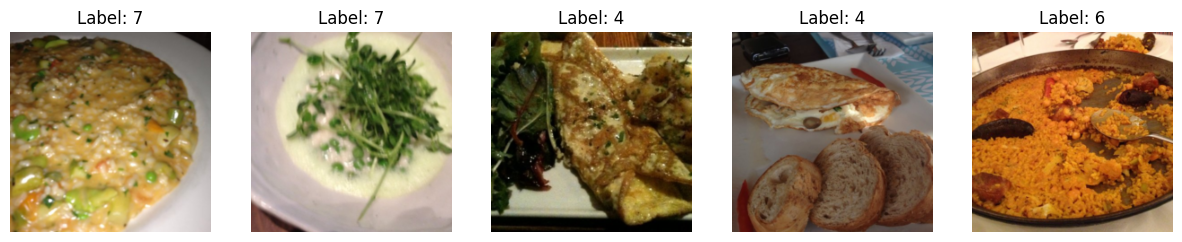

샘플 라벨 5개 출력:
tensor([4, 1, 0, 7, 3])


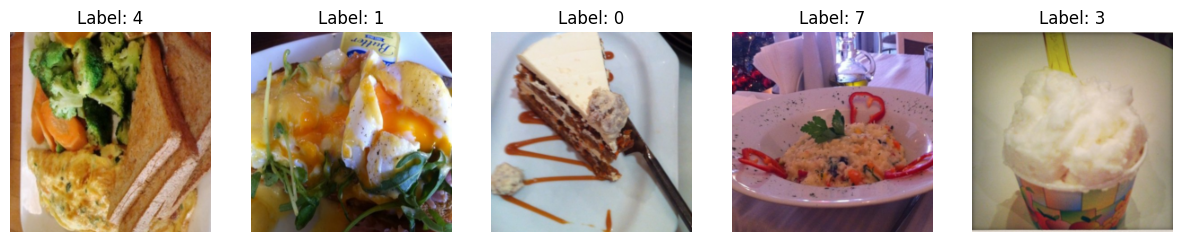

In [41]:
# 데이터 로더에서 샘플 배치 확인
def check_labels(dataloader, num_samples=5):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)  # 첫 번째 배치 가져오기

    print(f"샘플 라벨 {num_samples}개 출력:")
    print(labels[:num_samples])  # 첫 num_samples개의 라벨 출력

    # 시각화 (이미지 & 라벨 확인)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).numpy()  # 채널 차원 변경 (PyTorch -> NumPy)
        img = (img * 0.5) + 0.5  # 정규화 되돌리기 (Normalize 반전)

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {labels[i].item()}")
        axes[i].axis("off")

    plt.show()

# 학습 데이터 로더에서 확인
check_labels(train_loader)

# 검증 데이터 로더에서도 확인 가능
check_labels(validation_loader)


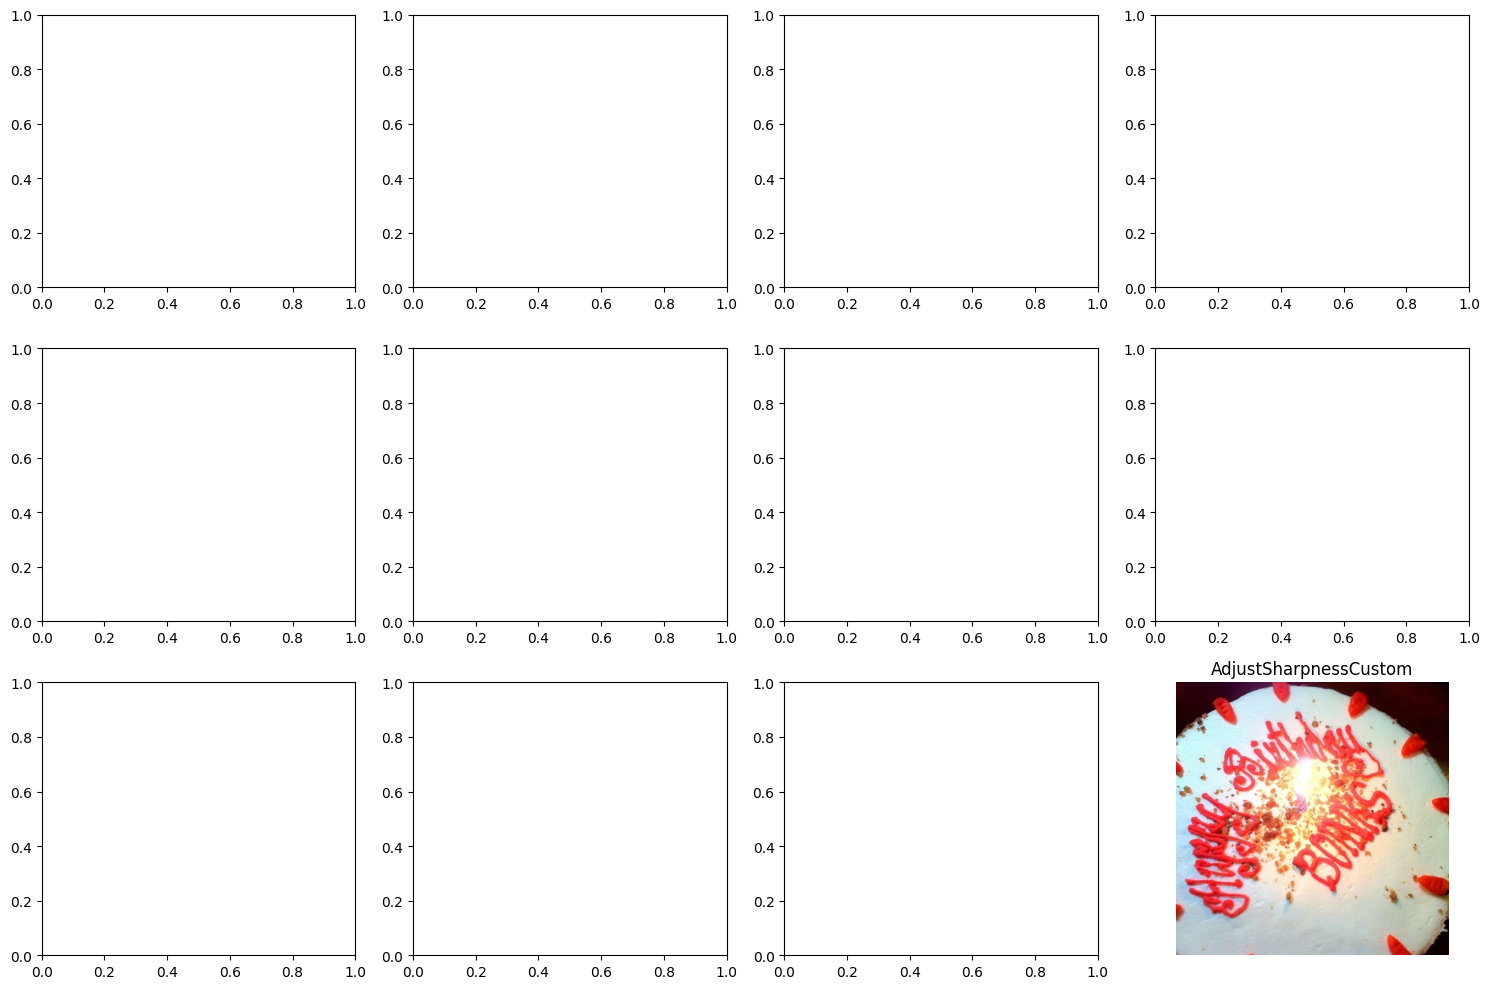

In [42]:

# 샘플 이미지 불러오기
sample_img_path, _ = image_datasets.samples[0]  # 데이터셋에서 첫 번째 이미지
sample_img = Image.open(sample_img_path).convert("RGB")  # RGB 변환

# 시드 고정 (랜덤 변환 결과 일관성 유지)
torch.manual_seed(42)

# Augmentation 과정별 변환 리스트 (랜덤 값 고정)
transform_steps = [
    ("Original", transforms.ToTensor()),
    ("RandomResizedCrop", transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
        transforms.ToTensor()
    ])),
    ("RandomHorizontalFlip", transforms.Compose([
        transforms.RandomHorizontalFlip(1.0),  # 항상 실행
        transforms.ToTensor()
    ])),
    ("RandomRotation", transforms.Compose([
        transforms.RandomRotation(degrees=20),
        transforms.ToTensor()
    ])),
    ("RandomAffine", transforms.Compose([
        transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1)),
        transforms.ToTensor()
    ])),
    ("ColorJitter", transforms.Compose([
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.3, hue=0.08),
        transforms.ToTensor()
    ])),
    ("RandomPerspective", transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.2, p=1.0),  # 항상 실행
        transforms.ToTensor()
    ])),
    ("GaussianBlur", transforms.Compose([
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=1.0),
        transforms.ToTensor()
    ])),
    ("RandomErasing", transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomErasing(p=1.0, scale=(0.02, 0.1), ratio=(0.3, 3.3))
    ])),
    ("CenterCrop", transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])),
    ("AdjustSharpnessCustom", transforms.Compose([
        AdjustSharpnessCustom(1.5),
        transforms.ToTensor()
    ]))
]

# 이미지 출력 함수
def show_image(tensor, title):
    img = tensor.numpy().transpose((1, 2, 0))  # (C, H, W) → (H, W, C)
    img = (img - img.min()) / (img.max() - img.min())  # 0~1 범위로 정규화
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

# 변환된 이미지 출력
fig, axes = plt.subplots(3, 4, figsize=(15, 10))

# 각 변환을 순차적으로 적용
for ax, (name, transform) in zip(axes.flat, transform_steps):
    transformed_img = transform(sample_img)  # 변환 적용
    show_image(transformed_img, name)

plt.tight_layout()
plt.show()


In [43]:
import torch.nn as nn
import torchvision.models as models

# ResNet152 모델 정의
class ResNet152_Custom(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet152_Custom, self).__init__()
        self.resnet = models.resnet152(weights=None)  # 사전 훈련된 가중치 X
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)  # FC Layer 변경

    def forward(self, x):
        return self.resnet(x)

# 모델 생성 및 설정
model = ResNet152_Custom(num_classes=len(class_names))
model = model.to(DEVICE)  # 지정된 디바이스(CPU/GPU)로 이동


In [44]:
# CNN Feature Map 시각화 추가
def visualize_feature_maps(model, image, device):
    model.eval()
    image = image.unsqueeze(0).to(device)  # 배치 차원 추가
    with torch.no_grad():
        for name, layer in model.named_children():
            if isinstance(layer, torch.nn.Conv2d):  # 첫 번째 Conv 레이어만 시각화
                feature_map = layer(image)
                feature_map = feature_map.cpu().squeeze(0)  # 배치 차원 제거
                num_features = feature_map.shape[0]
                fig, axes = plt.subplots(1, min(num_features, 6), figsize=(15, 5))
                for i in range(min(num_features, 6)):
                    axes[i].imshow(feature_map[i], cmap='viridis')
                    axes[i].axis('off')
                plt.show()
                break  # 첫 번째 Conv 레이어만 시각화하고 종료

# 입력 이미지 상위 5개 예측 결과 출력 함수 추가
def predict_top5(model, image, class_names, device):
    model.eval()
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image)
        probs = F.softmax(outputs, dim=1)
        top5_probs, top5_indices = torch.topk(probs, 5)

    top5_probs = top5_probs.cpu().numpy().flatten()
    top5_indices = top5_indices.cpu().numpy().flatten()

    print("Top 5 Predictions:")
    for i in range(5):
        print(f"{class_names[top5_indices[i]]}: {top5_probs[i] * 100:.2f}%")

def ResNet152(num_classes=10):
    return ResNet(BottleNeck, [3, 8, 36, 3], num_classes=num_classes)

# 모델 생성 및 설정
model = ResNet152(num_classes=len(class_names))
model = model.to(DEVICE)


In [45]:
# 손실 함수 및 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)

In [46]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3, verbose=True)


In [47]:
from collections import Counter

labels = [label for _, label in image_datasets.samples]
class_counts = Counter(labels)
print(class_counts)  # 클래스별 데이터 개수 출력


Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 999, 9: 30})


In [48]:
# 모델 저장 & 로드 함수
def save_model(model, path="best_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"✅ 모델 저장 완료: {path}")

def load_model(model, path="best_model.pth", device="cpu"):
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    print(f"🔹 Model loaded from {path} to {device}")
    return model

# 추가: 누락된 validate_model 함수
def validate_model(model, validation_loader, device):
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(validation_loader)
    val_acc = val_correct / val_total
    return avg_val_loss, val_acc

In [49]:
# 학습 과정 그래프 그리기 함수
def plot_training(history):
    # Validation metrics are calculated every 5 epochs
    # So, we need to adjust the x-axis for validation data
    val_epochs = range(5, len(history["train_loss"]) + 1, 5)

    plt.figure(figsize=(12, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(history["train_loss"]) + 1), history["train_loss"], label="Train Loss", marker="o")
    plt.plot(val_epochs, history["val_loss"], label="Validation Loss", marker="o") # Use val_epochs here
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(history["train_acc"]) + 1), history["train_acc"], label="Train Accuracy", marker="o")
    plt.plot(val_epochs, history["val_acc"], label="Validation Accuracy", marker="o") # Use val_epochs here
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid()

    plt.show()

In [50]:
# Early Stopping 설정
num_epochs = 20
patience = 5  # 검증 손실이 개선되지 않아도 몇 epoch까지 기다릴지
best_loss = float("inf")  # 최소 Validation Loss 저장
counter = 0  # Early Stopping 체크용 카운터

# 학습 기록 저장용
history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

# 체크포인트 저장 경로
checkpoint_path = "checkpoint.pth"

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        train_loader_tqdm.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")

    # 학습 기록 저장
    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(train_acc)

    # 5 epoch마다 Validation 수행
    if (epoch + 1) % 5 == 0:
        model.eval()
        avg_val_loss, val_acc = validate_model(model, validation_loader, DEVICE)

        print(f"🔹 Validation at Epoch {epoch+1}: Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

        history["val_loss"].append(avg_val_loss)
        history["val_acc"].append(val_acc)

        # Early Stopping 체크
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            counter = 0  # 개선되었으므로 counter 초기화
            # 체크포인트 저장
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_val_loss,
            }
            torch.save(checkpoint, checkpoint_path)
            print(f"✅ Checkpoint saved at epoch {epoch+1}, loss: {avg_val_loss:.4f}")
        else:
            counter += 1  # 개선되지 않았으므로 counter 증가
            print(f"⚠️ Early Stopping Counter: {counter}/{patience}")

        # 학습률 스케줄러 호출 (여기 추가)
        scheduler.step(avg_val_loss)

        # patience 이상으로 개선이 없으면 학습 중단
        if counter >= patience:
            print("⛔ Early stopping triggered! Training stopped.")
            break

# 체크포인트에서 최적 모델 불러오기
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print(f"✅ Model restored from checkpoint at epoch {checkpoint['epoch']}, loss: {checkpoint['loss']:.4f}")

# 학습 종료 후 최종 Validation 수행
final_val_loss, final_val_acc = validate_model(model, validation_loader, DEVICE)
print(f"🔹 Final Validation Loss: {final_val_loss:.4f}, Final Validation Accuracy: {final_val_acc:.4f}")


Epoch 1/20: 100%|██████████| 198/198 [03:02<00:00,  1.08it/s, loss=2.43]


Epoch 1/20, Train Loss: 2.3180, Train Acc: 0.1761


Epoch 2/20: 100%|██████████| 198/198 [03:02<00:00,  1.09it/s, loss=2.09]


Epoch 2/20, Train Loss: 2.1198, Train Acc: 0.2153


Epoch 3/20: 100%|██████████| 198/198 [03:00<00:00,  1.10it/s, loss=2.08]


Epoch 3/20, Train Loss: 2.0393, Train Acc: 0.2463


Epoch 4/20: 100%|██████████| 198/198 [03:00<00:00,  1.09it/s, loss=1.97]


Epoch 4/20, Train Loss: 1.9657, Train Acc: 0.2746


Epoch 5/20: 100%|██████████| 198/198 [03:01<00:00,  1.09it/s, loss=1.84]


Epoch 5/20, Train Loss: 1.9323, Train Acc: 0.2893
🔹 Validation at Epoch 5: Val Loss: 1.8742, Val Acc: 0.3136
✅ Checkpoint saved at epoch 5, loss: 1.8742


Epoch 6/20: 100%|██████████| 198/198 [03:01<00:00,  1.09it/s, loss=1.99]


Epoch 6/20, Train Loss: 1.9082, Train Acc: 0.3035


Epoch 7/20: 100%|██████████| 198/198 [03:01<00:00,  1.09it/s, loss=1.98]


Epoch 7/20, Train Loss: 1.8999, Train Acc: 0.3138


Epoch 8/20: 100%|██████████| 198/198 [03:01<00:00,  1.09it/s, loss=1.95]


Epoch 8/20, Train Loss: 1.8415, Train Acc: 0.3363


Epoch 9/20: 100%|██████████| 198/198 [03:01<00:00,  1.09it/s, loss=1.72]


Epoch 9/20, Train Loss: 1.7933, Train Acc: 0.3538


Epoch 10/20: 100%|██████████| 198/198 [03:01<00:00,  1.09it/s, loss=1.67]


Epoch 10/20, Train Loss: 1.7908, Train Acc: 0.3556
🔹 Validation at Epoch 10: Val Loss: 1.8619, Val Acc: 0.3380
✅ Checkpoint saved at epoch 10, loss: 1.8619


Epoch 11/20: 100%|██████████| 198/198 [03:00<00:00,  1.09it/s, loss=1.96]


Epoch 11/20, Train Loss: 1.7457, Train Acc: 0.3896


Epoch 12/20: 100%|██████████| 198/198 [03:01<00:00,  1.09it/s, loss=1.73]


Epoch 12/20, Train Loss: 1.7245, Train Acc: 0.3864


Epoch 13/20: 100%|██████████| 198/198 [03:01<00:00,  1.09it/s, loss=1.84]


Epoch 13/20, Train Loss: 1.6961, Train Acc: 0.4000


Epoch 14/20: 100%|██████████| 198/198 [03:01<00:00,  1.09it/s, loss=2.04]


Epoch 14/20, Train Loss: 1.6401, Train Acc: 0.4253


Epoch 15/20: 100%|██████████| 198/198 [03:01<00:00,  1.09it/s, loss=1.22]


Epoch 15/20, Train Loss: 1.5998, Train Acc: 0.4367
🔹 Validation at Epoch 15: Val Loss: 1.6082, Val Acc: 0.4499
✅ Checkpoint saved at epoch 15, loss: 1.6082


Epoch 16/20: 100%|██████████| 198/198 [03:00<00:00,  1.10it/s, loss=1.78]


Epoch 16/20, Train Loss: 1.5337, Train Acc: 0.4614


Epoch 17/20: 100%|██████████| 198/198 [03:01<00:00,  1.09it/s, loss=1.87]


Epoch 17/20, Train Loss: 1.5104, Train Acc: 0.4692


Epoch 18/20: 100%|██████████| 198/198 [03:01<00:00,  1.09it/s, loss=1.48]


Epoch 18/20, Train Loss: 1.4732, Train Acc: 0.4959


Epoch 19/20: 100%|██████████| 198/198 [03:01<00:00,  1.09it/s, loss=1.61]


Epoch 19/20, Train Loss: 1.3956, Train Acc: 0.5190


Epoch 20/20: 100%|██████████| 198/198 [03:01<00:00,  1.09it/s, loss=1.36]


Epoch 20/20, Train Loss: 1.3532, Train Acc: 0.5383
🔹 Validation at Epoch 20: Val Loss: 1.5452, Val Acc: 0.4698
✅ Checkpoint saved at epoch 20, loss: 1.5452


<ipython-input-50-68d9b28ae055>:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


✅ Model restored from checkpoint at epoch 20, loss: 1.5452
🔹 Final Validation Loss: 1.5452, Final Validation Accuracy: 0.4698


In [51]:

# 테스트 데이터 평가 함수 정의
def test_model(model, test_loader, device):
    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)

    avg_test_loss = test_loss / len(test_loader)
    test_acc = test_correct / test_total
    return avg_test_loss, test_acc

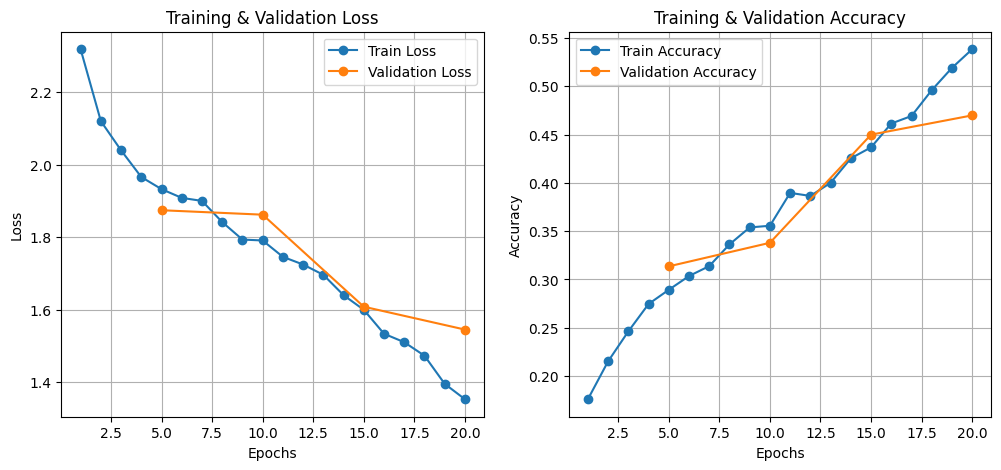

평균 손실: 1.5680
정확도: 44.79%


In [52]:
# 학습 과정 그래프 그리기
plot_training(history)

# 테스트 데이터 평가 실행
avg_test_loss, test_acc = test_model(model, test_loader, DEVICE)
print(f"평균 손실: {avg_test_loss:.4f}")
print(f"정확도: {test_acc * 100:.2f}%")

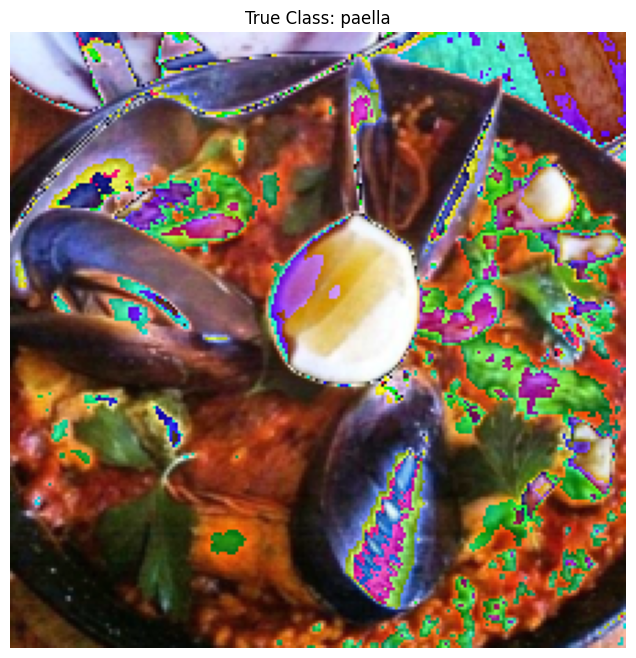

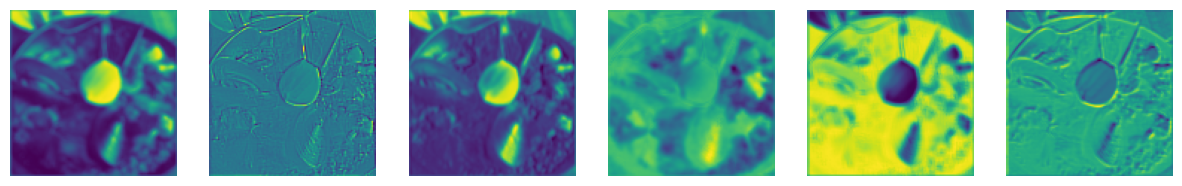

Top 5 Predictions:
french_toast: 42.10%
paella: 23.08%
carrot_cake: 11.59%
ice_cream: 7.38%
omelette: 6.12%


In [53]:
# 샘플 이미지에 대한 예측 및 시각화 예시 코드
def visualize_sample_predictions():
    # 테스트 세트에서 몇 개의 샘플 가져오기
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # 샘플 이미지 선택
    sample_idx = 0
    sample_image = images[sample_idx]
    sample_label = labels[sample_idx]

    # 원본 이미지 표시
    plt.figure(figsize=(8, 8))
    plt.imshow(transforms.ToPILImage()(sample_image))
    plt.title(f"True Class: {class_names[sample_label]}")
    plt.axis('off')
    plt.show()

    # 특성 맵 시각화
    visualize_feature_maps(model, sample_image, DEVICE)

    # 상위 5개 예측 결과 출력
    predict_top5(model, sample_image, class_names, DEVICE)

# 샘플 이미지에 대한 시각화 실행
visualize_sample_predictions()